# Data Mining and Exploration [INFR11007]

# Lab 3: Unsupervised dimensionality reduction

In this lab we look at various unsupervised dimensionality reduction methods. By reducing the dimensionality to two or three dimensions only, we can visualise the data e.g. by scatter plots.

When we deal with labeled data, we hope that in the low-dimensional space the classes are well-separated, that is, the transformed low-dimensional data form clusters which corresond to the different classes.

Similar to Lab 1, we make use of the [landsat satellite](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29) dataset which is 36-dimensional and comprises 6 classes.

As always, we first need to import the required python packages.

In [1]:
# Import required packages 
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
%matplotlib inline

### ========== Question 1 ==========
Load the `landsat_train.csv` dataset into a `pandas` DataFrame called  `landsat_train` and display the shape of the DataFrame.

In [2]:
# Your code goes here
labels_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_classes.csv')
landsat_labels = pd.read_csv(labels_path, delimiter=',', index_col=0)
landsat_labels
landsat_labels_dict = landsat_labels.to_dict()["Class"]

train_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_train.csv')
test_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_test.csv')
landsat_train = pd.read_csv(train_path, delimiter=',')
landsat_test = pd.read_csv(test_path, delimiter=',')




### ========== Question 2 ==========
Load the dataset class names into a DataFrame called `landsat_labels`.  By using the `to_dict()` method convert this DataFrame into a single dictionary. Alternatively, you can make use of  the `DictReader()` function which should be loaded from the `csv` module. There is also the option to use `numpy's` `genfromtxt()` function. You are free to choose the method that suits you best, but you should inspect the final dictionary to make sure it looks as expected.

In [ ]:
# Your code goes here


Now we want to replace the label numbers in the `landsat_train` DataFrame with the corresponding class names. We can achieve that by using the `pandas` function `replace()`. The `inplace` argument determines whether the method alters the object it is called upon and returns nothing, or returns a new object (when `inplace` is set to `False`).  

Execute the cell below which performs this replacement. The second line is used to show a random sample of 5 entries of the DataFrame for us to inspect the outcome of this transformation.

In [3]:
# Replace label numbers with their names
landsat_train.replace({'label' : landsat_labels_dict}, inplace=True)
landsat_train.sample(n=5, random_state=10)

,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_3_1,pixel_3_2,...,pixel_7_4,pixel_8_1,pixel_8_2,pixel_8_3,pixel_8_4,pixel_9_1,pixel_9_2,pixel_9_3,pixel_9_4,label
2893,67,81,86,64,67,81,82,64,67,77,...,65,68,77,86,65,72,81,86,68,very damp grey soil
43,80,94,102,83,76,89,98,79,68,77,...,83,79,91,104,79,75,79,96,79,soil with vegetation stubble
942,46,32,133,136,46,32,133,136,46,32,...,140,44,34,129,140,44,34,124,136,cotton crop
349,89,102,110,87,93,106,114,90,93,111,...,88,88,107,118,88,88,107,113,88,grey soil
4204,49,77,93,75,46,66,86,72,49,70,...,76,50,73,90,76,50,73,94,79,red soil


Now, we would like to separate the input features from the labels and store them into two `numpy` arrays. 

We will need two things:
* the `pandas` `drop()`  can be used to discard a specified axis in a DataFrame. We will use it to drop the `label` column.
* the `values` attribute of a DataFrame contains all valus in a `numpy array` format.

In [6]:
x = landsat_train.drop('label', axis=1).values # Input features
y = landsat_train['label'].values # Labels
print('Dimensionality of X: {}\nDimensionality of y: {}'.format(x.shape, y.shape))

Dimensionality of X: (4435, 36)
Dimensionality of y: (4435,)


## General note on scikit-learn methods

All supervised estimators in scikit-learn implement a `fit(X, y)` method which can be used fit the model, and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

Unsupervised methods and transformations still implement `fit(X)` but not `predict(X)`. Instead, they implement a `transform(X)` method which can be called once a model has been fit to transform the data in `X`. Most often, these two steps can be combined together by using the `fit_transform(X)` method when available.

### ========== Question 3 ==========

Display the means and standard deviations of the first 4 columns of `X`. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [7]:
# Your code goes here
pixelMeans = []

for p in range(0,36):
    m = np.average(x[:,p], axis=0)
    sd = np.std(x[:,p], axis=0)
    t = (m,sd)
    pixelMeans.append(t)

    
for i in range(0,4):
    print("Mean for Pixel1_{0} is : {1}".format(i,pixelMeans[i][0]))
    print("SD for Pixel1_{0} is : {1}".format(i, pixelMeans[i][1]))


Mean for Pixel1_0 is : 69.47395715896279
SD for Pixel1_0 is : 13.648095721011396
Mean for Pixel1_1 is : 83.85524239007891
SD for Pixel1_1 is : 22.722516462009114
Mean for Pixel1_2 is : 99.3228861330327
SD for Pixel1_2 is : 16.67028644909299
Mean for Pixel1_3 is : 82.55558060879369
SD for Pixel1_3 is : 18.693342353314012


## Data pre-processing: feature standardisation


**Feature standardisation** is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about feature standardisation in the lecture notes and [here](http://scikit-learn.org/stable/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

As you might expect, scikit-learn offers an [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. 

### ========== Question 4 ========== 

Create a `StandardScaler` and fit it by using `X`. Then transform the array by using the scaler you just fit and save the results in a new array `X_sc`.

Finally, display the means and standard deviations of the first 4 columns of `X_sc`. Do the look as expected?

**For the rest of this lab you should use the standardised data (i.e. `X_sc`), unless you are explicitly asked to do otherwise.**

In [8]:
from sklearn.preprocessing import StandardScaler
# Your code goes here
#  Data Standardisation
stan = StandardScaler()
stan.fit(x)
xStandard = stan.transform(x)

pixelMeansStandard = []

for p in range(0,36):
    m = np.average(xStandard[:,p], axis=0)
    sd = np.std(xStandard[:,p], axis=0)
    t = (m,sd)
    pixelMeansStandard.append(t)

for i in range(0,4):
    print("Mean for Pixel1_{0} is : {1}".format(i,pixelMeansStandard[i][0]))
    print("SD for Pixel1_{0} is : {1}".format(i, pixelMeansStandard[i][1]))



Mean for Pixel1_0 is : 4.357781829238946e-16
SD for Pixel1_0 is : 0.9999999999999999
Mean for Pixel1_1 is : 1.5380406456137456e-16
SD for Pixel1_1 is : 1.0
Mean for Pixel1_2 is : -1.0574029438594502e-16
SD for Pixel1_2 is : 0.9999999999999999
Mean for Pixel1_3 is : -1.922550807017182e-16
SD for Pixel1_3 is : 1.0


C:\Users\uss2f\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


*Your answer goes here*

Results look as expected, features have now zero mean and unit standard deviation.

## Visualisation

In this lab we will be using various dimensionality reduction methods and visualise their outputs in 2D space by using scatter plots. For this, we provide a function `scatter_2d_label()` which creates a scatter plot of 2D data and also annotates the corresponding classes appropriately. Execute the following cell and make sure you understand what this function does.

In [9]:
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)

The following cell selects two columns of `X_sc` (i.e. features in the high-dimensional space) and uses the `scatter_2d_label()` function provided above to visualise the 2D scatter plots. Feel free to experiment with different selections of dimensions.

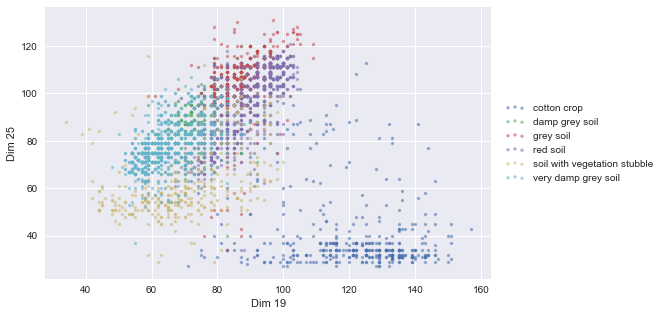

In [20]:
dim_1 = 19 # First dimension
dim_2 = 25 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(x[:, [dim_1,dim_2]], y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))
plt.show()

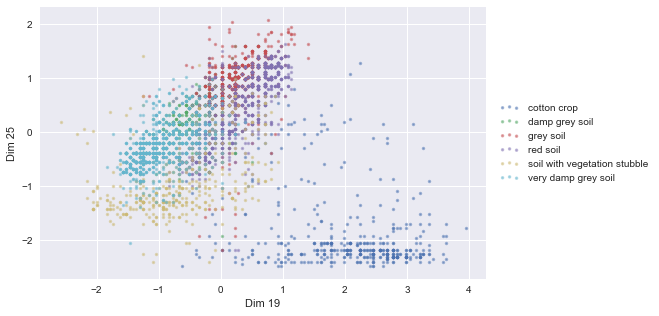

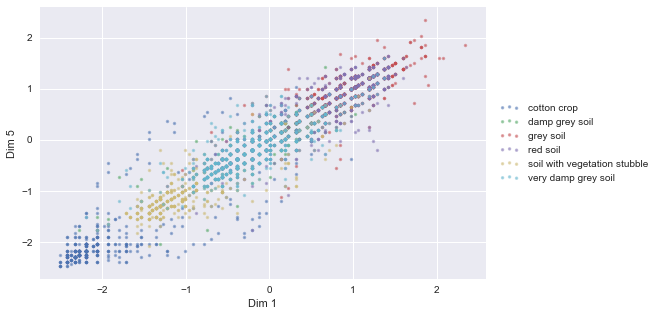

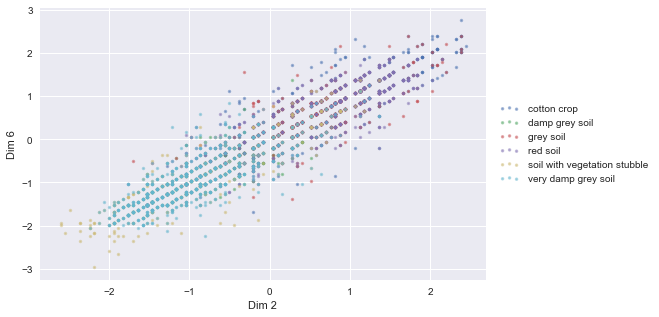

In [21]:
dim_1 = 19 # First dimension
dim_2 = 25 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(xStandard[:, [dim_1,dim_2]], y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))

dim_1 = 1 # First dimension
dim_2 = 5 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(xStandard[:, [dim_1,dim_2]], y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))

dim_1 = 2 # First dimension
dim_2 = 6 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(xStandard[:, [dim_1,dim_2]], y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))
plt.show()

### ========== Question 5 ========== 
Take a random 2D projection of the data by using all the original features and observe the 2D scatter plot in the embedded space. Do you observe any clusters?  

*Hint: set the `random_seed` parameter to an integer of your choice to ensure reproducible results.*

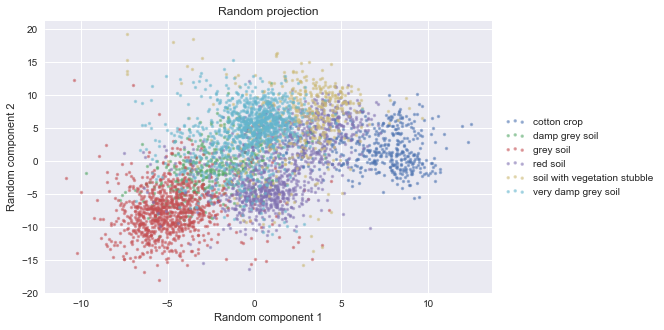

In [35]:
# Your code goes here

np.random.seed(seed=30) # Ensure reproducible results

randomWeights = np.random.randn(x.shape[1],2)
random_weights = np.random.randn(x.shape[1], 2)

randomProjection = np.dot(xStandard,randomWeights)

plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(randomProjection, y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Random component 1')
plt.ylabel('Random component 2')
plt.title('Random projection')
plt.show()




##  Principal component analysis (PCA)

In Lab 2, we saw how to implement principal component analysis (PCA). In this lab, we will use the [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) module in scikit-learn for dimensionality reduction. The cell below computes the PC scores from the (standardised) input data and makes use of the `scatter_2d_label()` function to visualise the outcome. Execute it and observe the outcome.

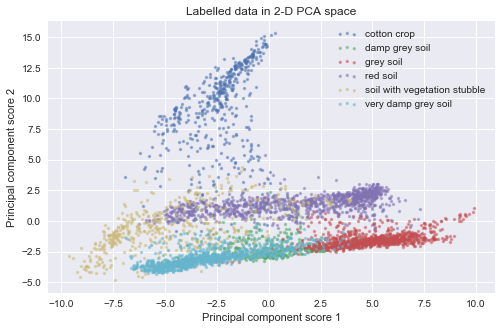

In [36]:
from sklearn.decomposition import PCA # Import the PCA module
X_pca_2d = PCA(n_components=2).fit_transform(xStandard) # Initialise a PCA instance, fit it by using X_sc and then transform X_sc
plt.figure(figsize=(8,5))
scatter_2d_label(X_pca_2d, y)
plt.title('Labelled data in 2-D PCA space')
plt.xlabel('Principal component score 1')
plt.ylabel('Principal component score 2')
plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()

## Kernel density estimate (KDE) in embedded space
Some times we might want to describe the data in the embedded space in a slightly better way than with just a scatter plot. For instance, we might be interested in where the density is.

### ========== Question 6 ========== 
By using the `scatter_2d_label()` function as a template, write a new function `kde_2d_label()` which shows kernily density estimates for the data in the embedded space. Individual densities should be estimated for each class and they should be shown in different colours.

*Hint. You should make use of the seaborn function `kdeplot()`.*

Next, use the function you just wrote to visualise the kernel density estimates of the PC scores for each class. Do not worry about adding a legend in your plot at this point.

In [37]:
# Your code goes here
# Your code goes here
def kde_2d_label(X_2d, y):
    """Kernel density estimate in a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels correspodning to the entries in X_2d.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        sns.kdeplot(X_2d[y == target, 0], X_2d[y == target, 1], cmap=sns.dark_palette(color, as_cmap=True))


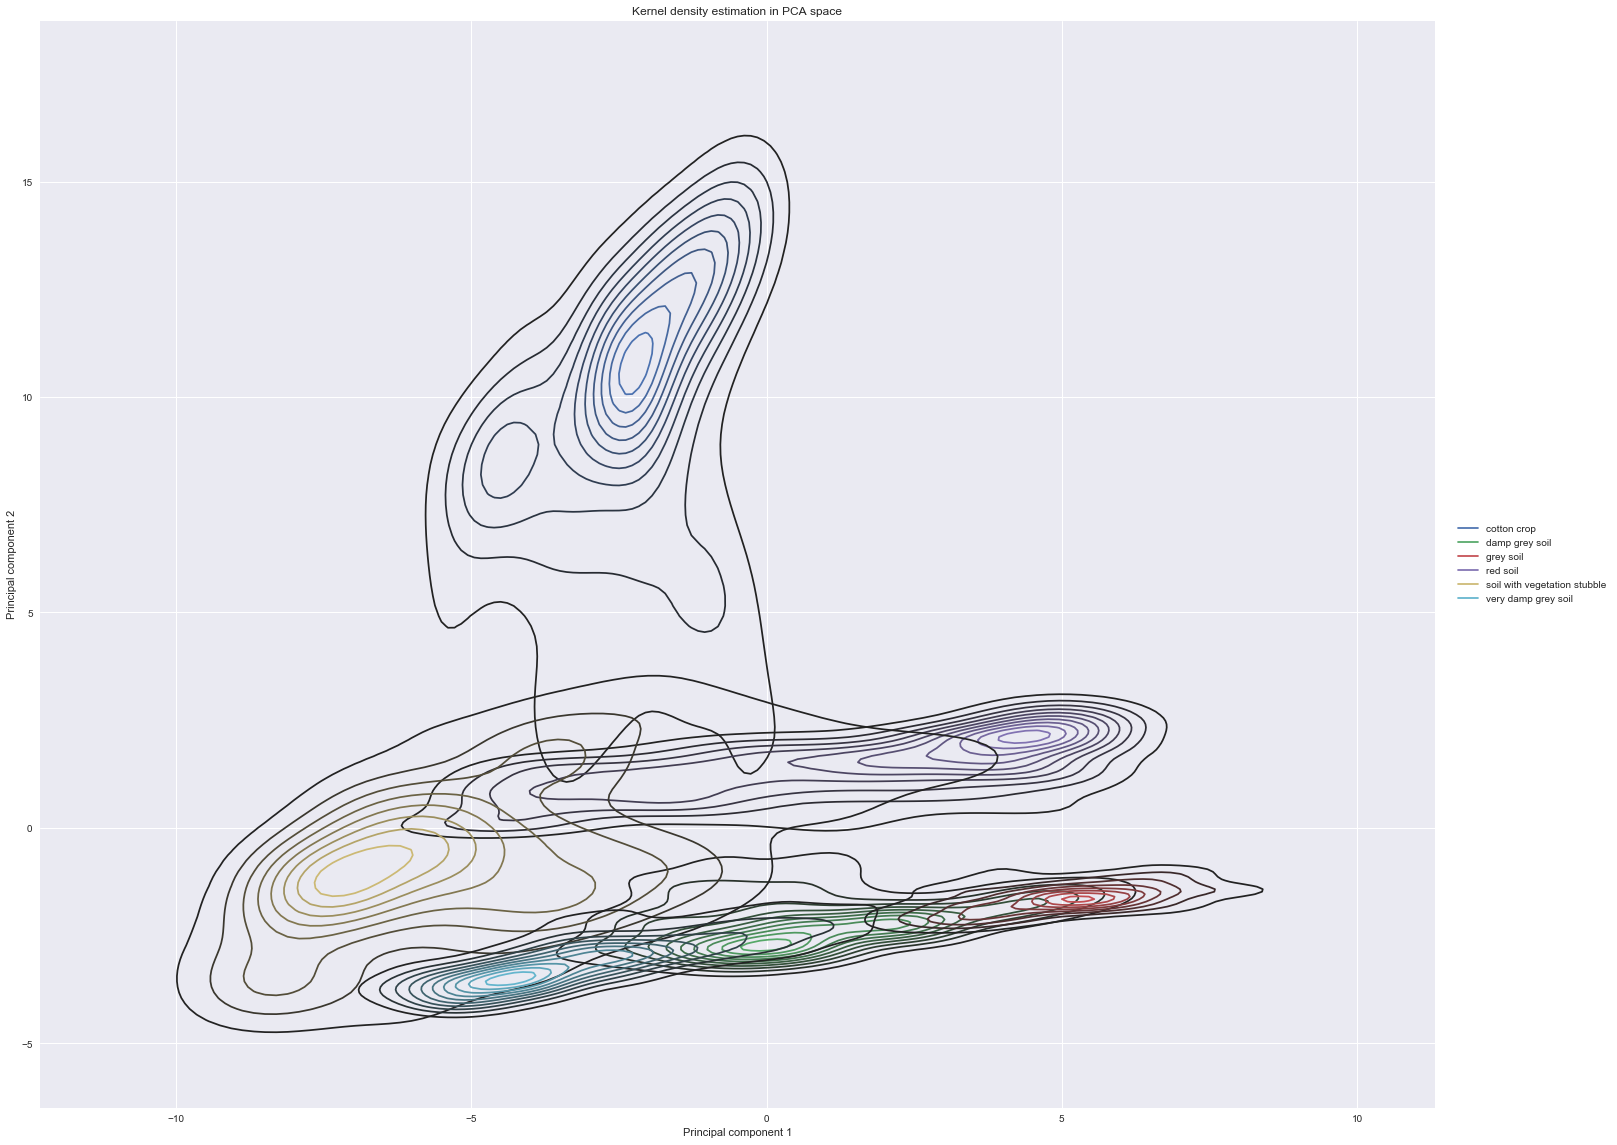

In [47]:
from sklearn.decomposition import PCA # Import the PCA module
import matplotlib.lines as mlines
cats = np.unique(y)
color_palette = sns.color_palette(n_colors=cats.size)
patches = [mlines.Line2D([], [], color=color_palette[ii], label=cat) for ii, cat in enumerate(cats)]

plt.figure(figsize=(25,20))
kde_2d_label(X_pca_2d, y)
plt.title('Kernel density estimation in PCA space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

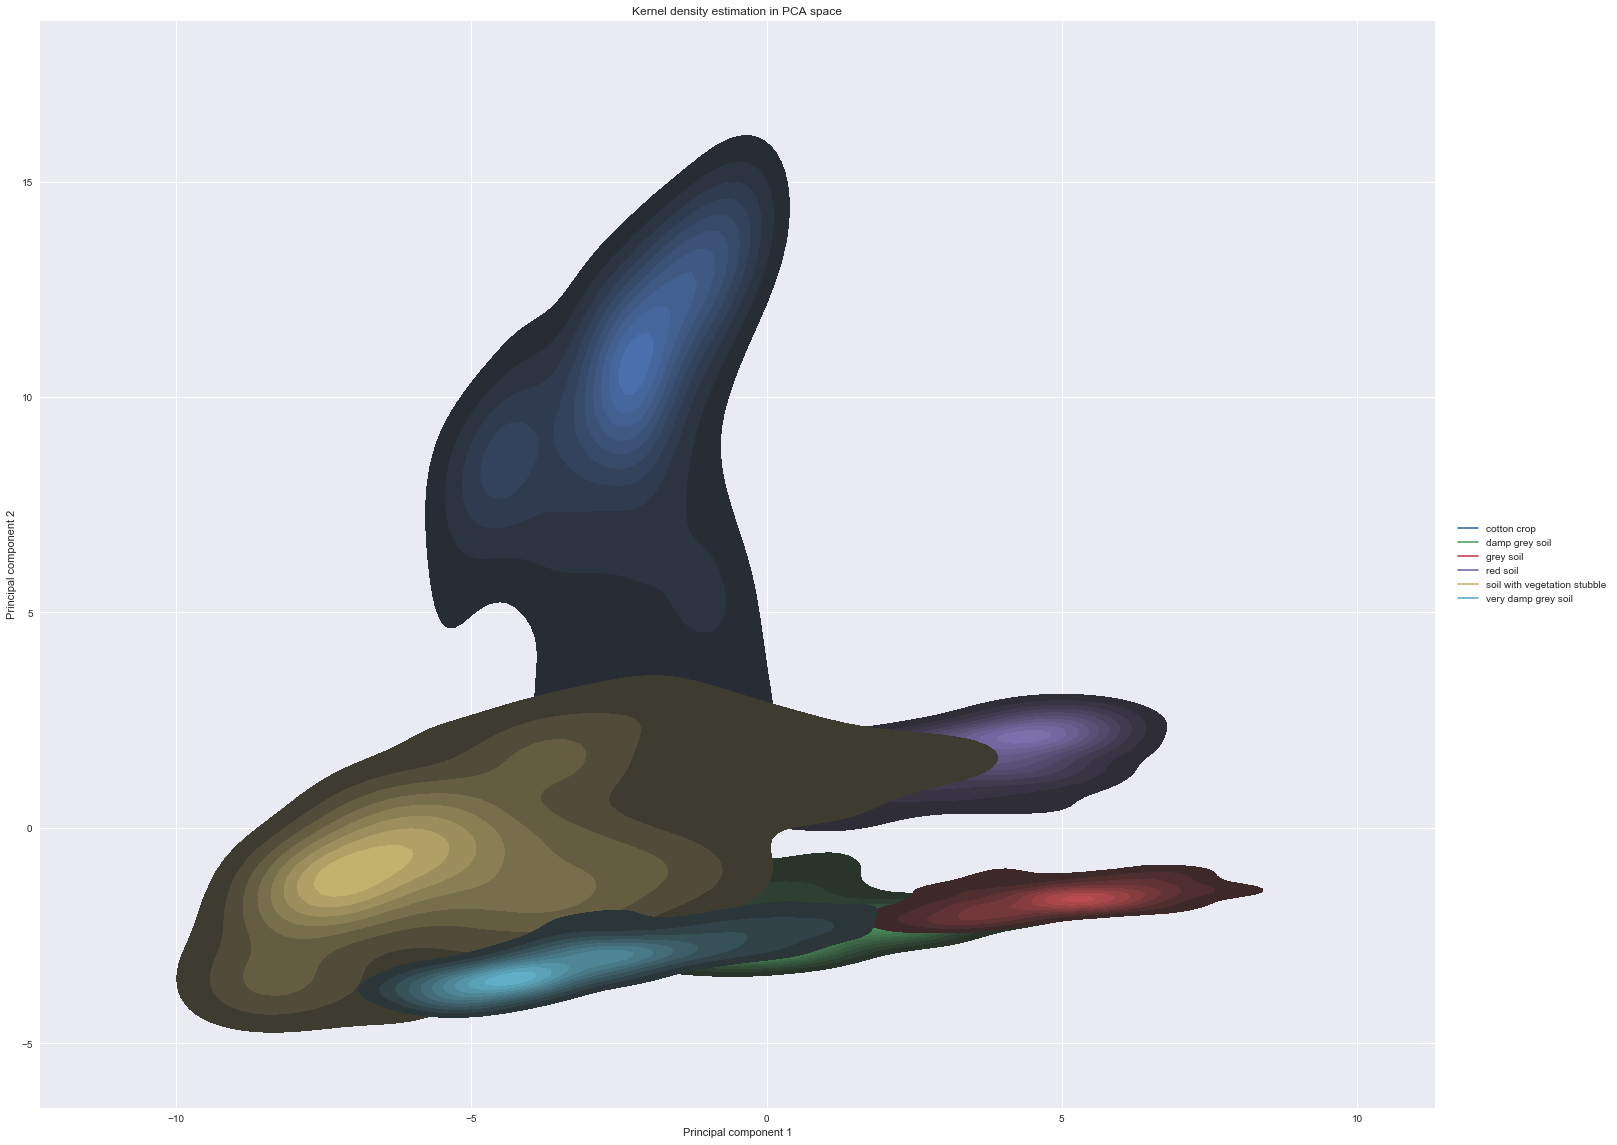

In [46]:
targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(25,20))
for color, target in zip(colors, targets):
    sns.kdeplot(X_pca_2d[y == target, 0], X_pca_2d[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation in PCA space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()


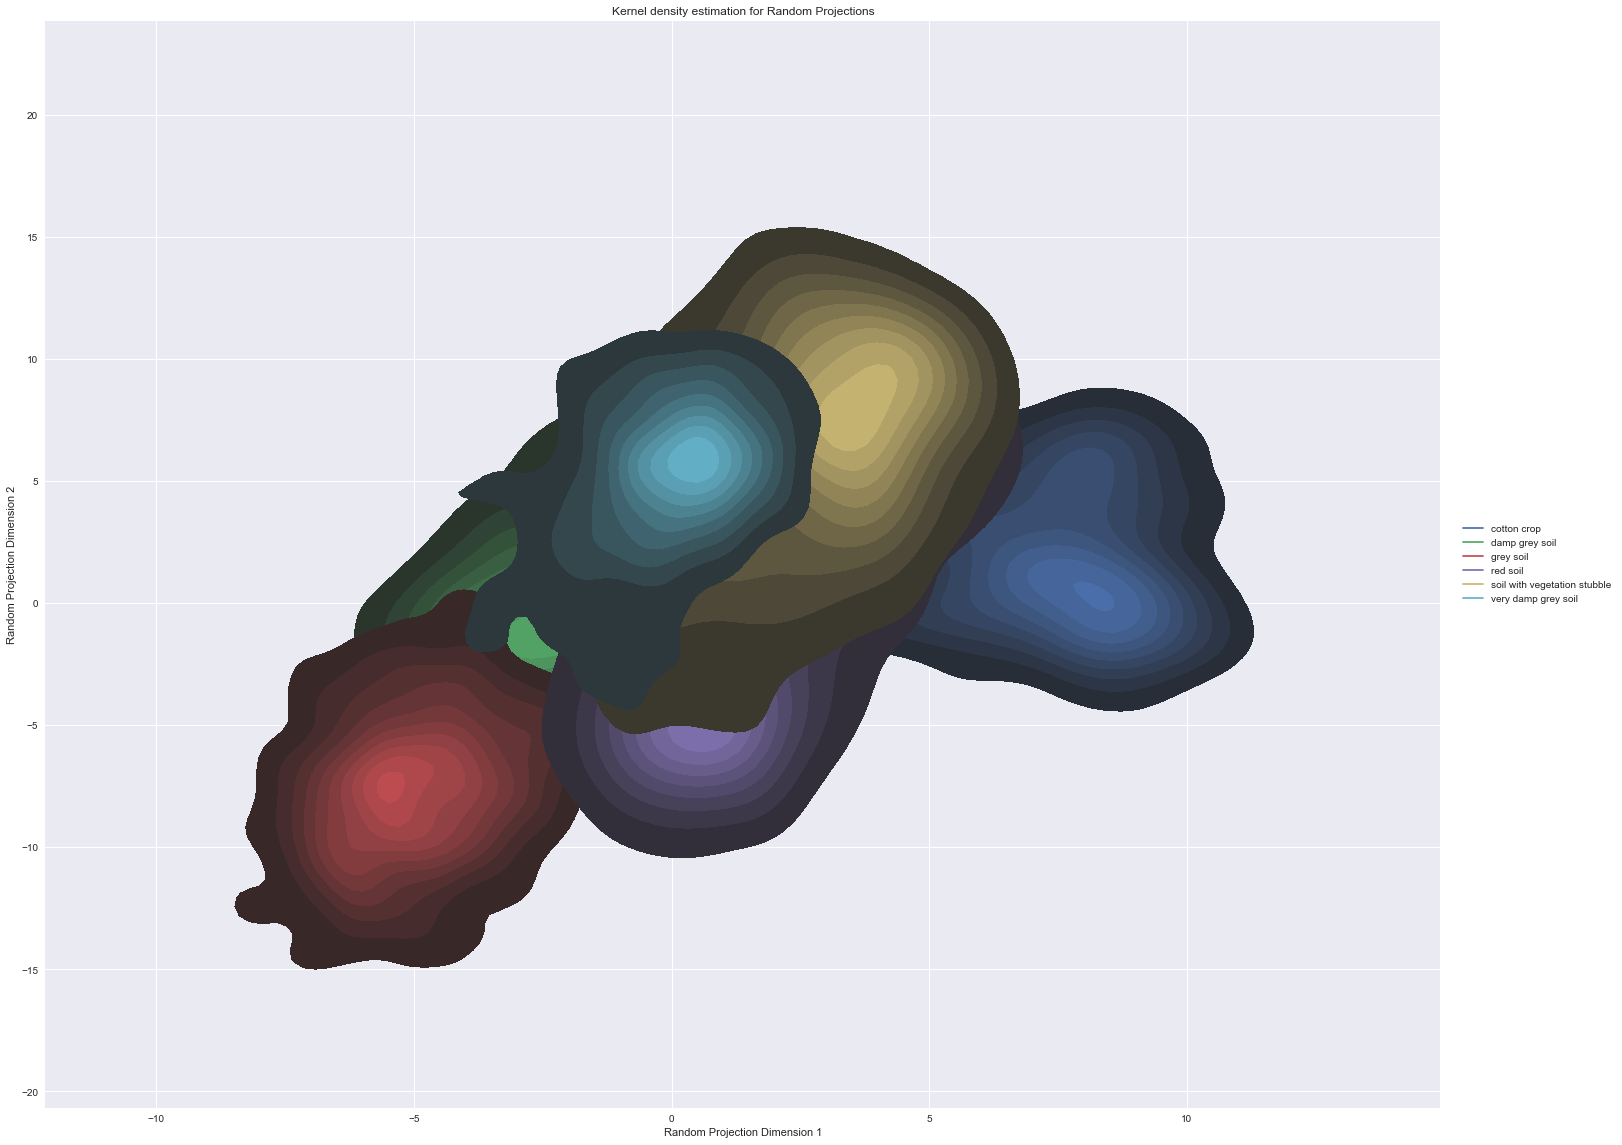

In [48]:
targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(25,20))
for color, target in zip(colors, targets):
    sns.kdeplot(randomProjection[y == target, 0], randomProjection[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Random Projection Dimension 1')
plt.ylabel('Random Projection Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

## Kernel principal component analysis (KPCA)

PCA is a linear method, in the sense that the reduced dimension representation is generated by linear projections and this can severely limit the usefulness of the approach. Several versions of nonlinear PCA have been proposed in the hope of overcoming this problem. One such algorithm is kernel PCA.

Kernel PCA applies the kernel trick to create a nonlinear version of PCA in sample space by performing ordinary PCA in the augmented kernel space (cf Lab 2, eigendecomposition of Gram matrix, and the lecture notes on kernel PCA).

Scikit-learn offers an implentation of KPCA which supports the use of various kernels.  Familiarise yourself with this class by reading the [user guide](http://scikit-learn.org/stable/modules/decomposition.html#kernel-pca) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA).


### ========== Question 7 ========== 

By using the `KernelPCA` module, apply kernel PCA to the standardised data in `X_sc`. Set the `n_components` parameter to `2` and use default settings for other parameters. Experiment with different kernels. How do the results differ when different kernels are used?

2


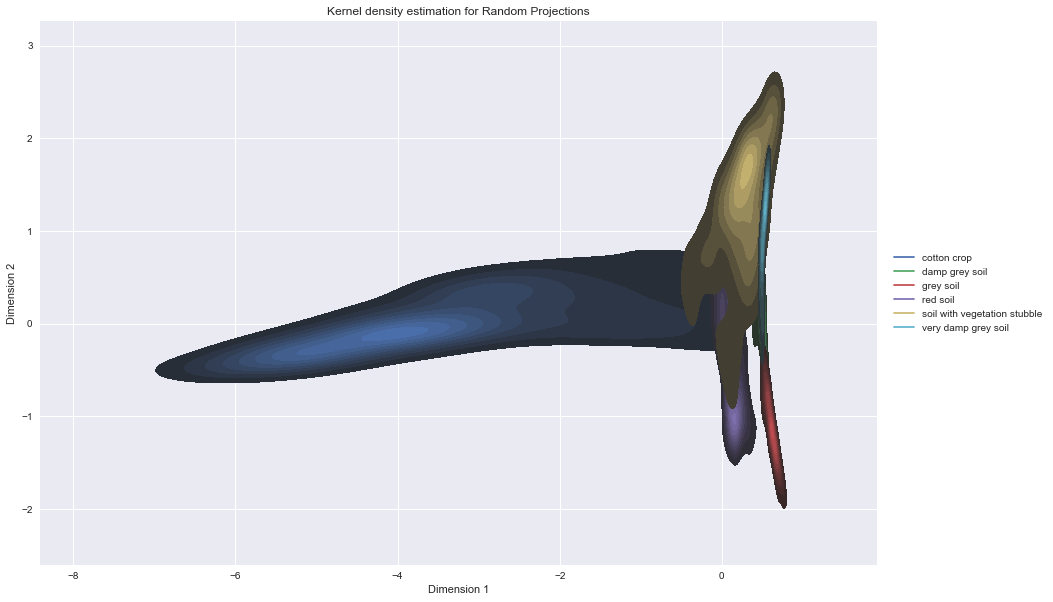

In [49]:
from sklearn.decomposition import KernelPCA
# Your code goes here
kernelpoly = KernelPCA(n_components=2, kernel="poly", degree=2)
kernelpoly.fit(xStandard)
xTranformedPoly = kernelpoly.transform(xStandard)
print(kernelpoly.n_components)

targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(15,10))
for color, target in zip(colors, targets):
    sns.kdeplot(xTranformedPoly[y == target, 0], xTranformedPoly[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()



2


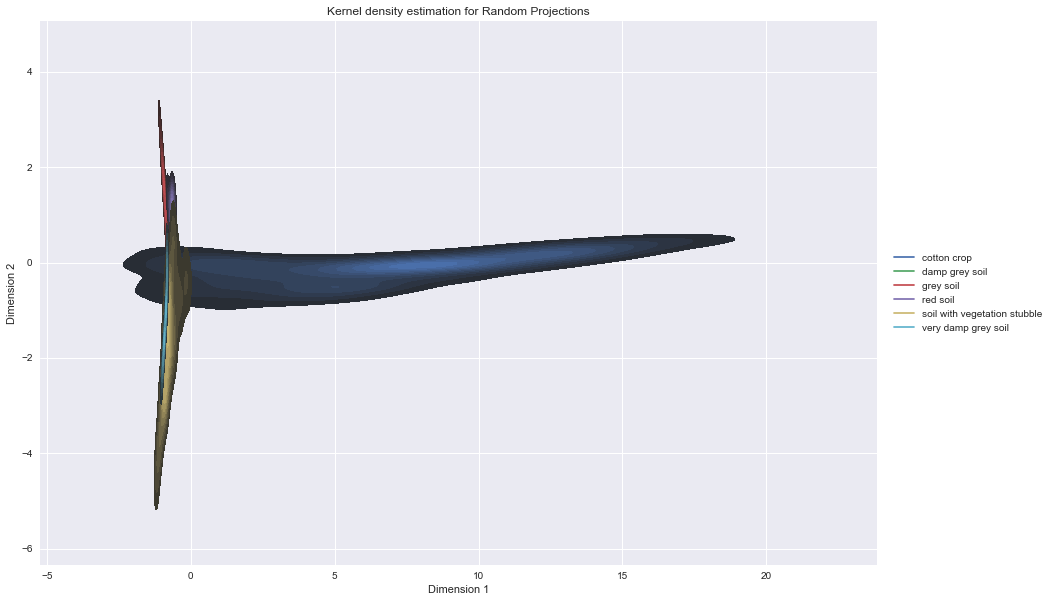

In [50]:
kernelpoly = KernelPCA(n_components=2, kernel="poly", degree=3)
kernelpoly.fit(xStandard)
xTranformedPoly = kernelpoly.transform(xStandard)
print(kernelpoly.n_components)

targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(15,10))
for color, target in zip(colors, targets):
    sns.kdeplot(xTranformedPoly[y == target, 0], xTranformedPoly[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

2


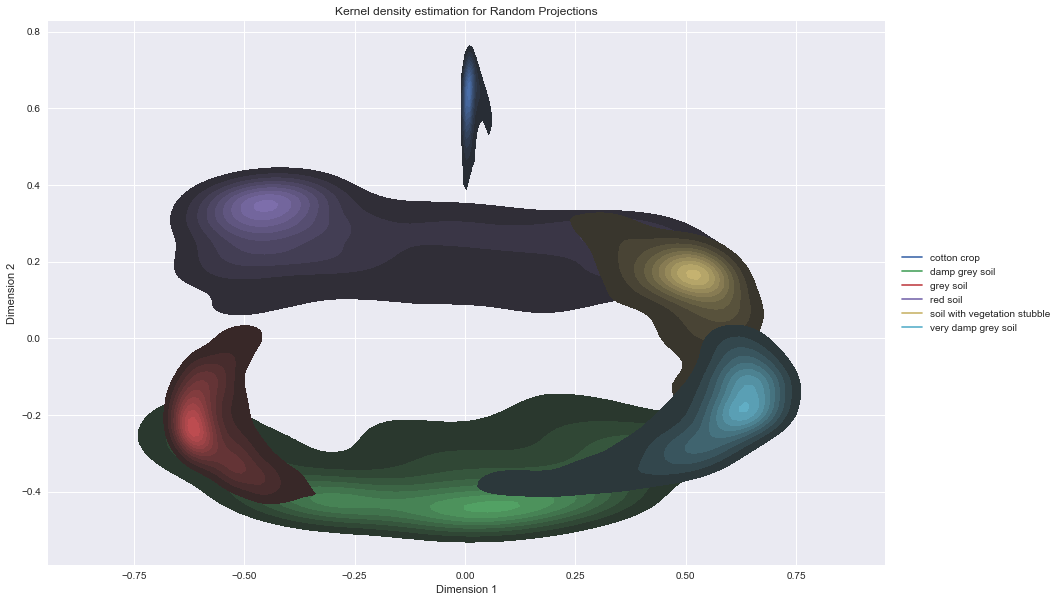

In [51]:
kernelpoly = KernelPCA(n_components=2, kernel="rbf")
kernelpoly.fit(xStandard)
xTranformedPoly = kernelpoly.transform(xStandard)
print(kernelpoly.n_components)

targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(15,10))
for color, target in zip(colors, targets):
    sns.kdeplot(xTranformedPoly[y == target, 0], xTranformedPoly[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

2


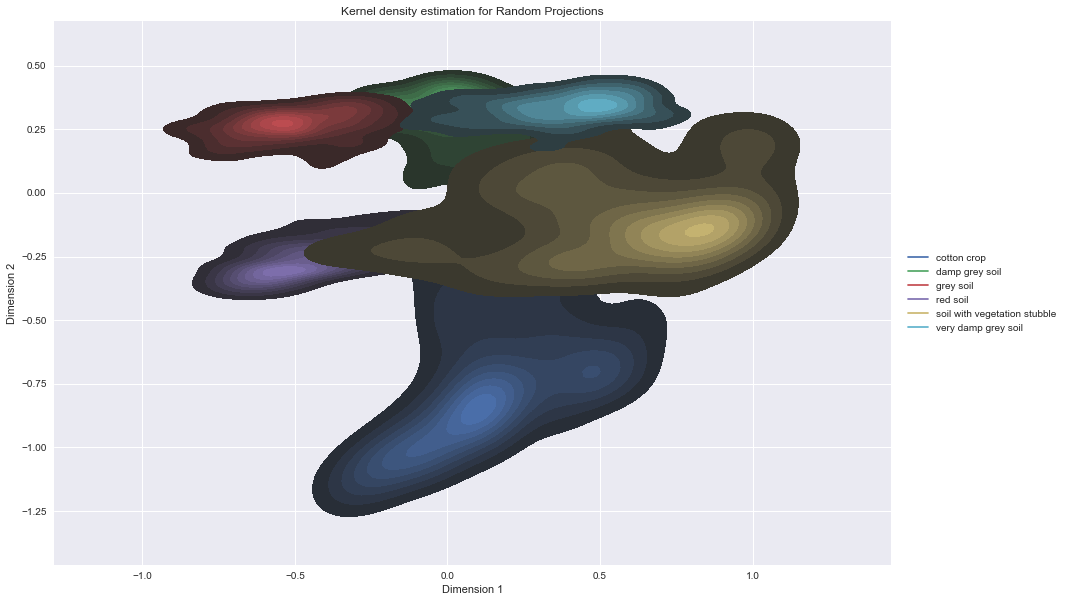

In [52]:
kernelpoly = KernelPCA(n_components=2, kernel="sigmoid")
kernelpoly.fit(xStandard)
xTranformedPoly = kernelpoly.transform(xStandard)
print(kernelpoly.n_components)

targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(15,10))
for color, target in zip(colors, targets):
    sns.kdeplot(xTranformedPoly[y == target, 0], xTranformedPoly[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

2


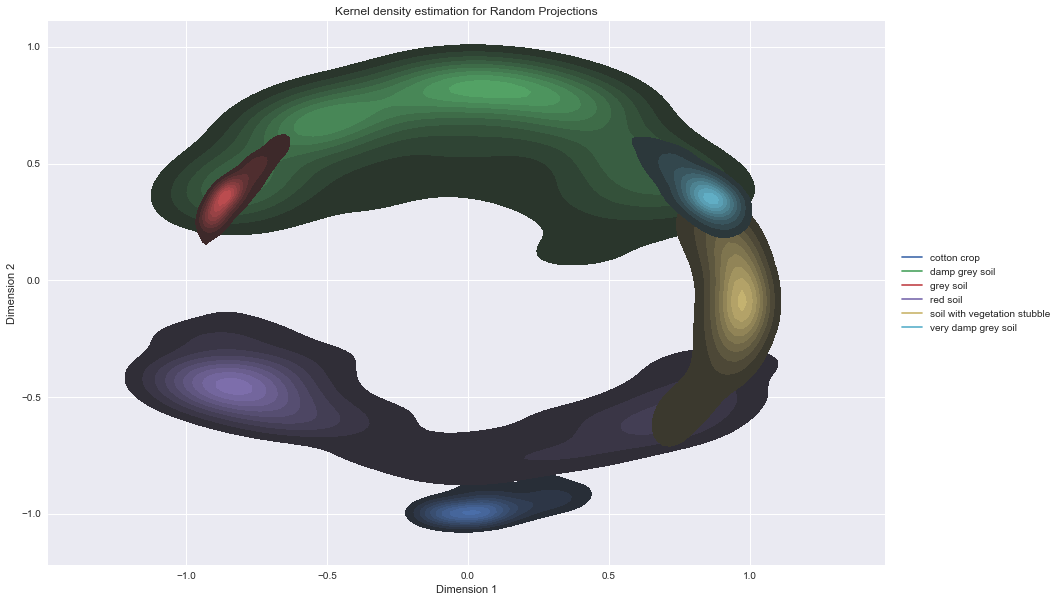

In [53]:
kernelpoly = KernelPCA(n_components=2, kernel="cosine")
kernelpoly.fit(xStandard)
xTranformedPoly = kernelpoly.transform(xStandard)
print(kernelpoly.n_components)

targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
plt.figure(figsize=(15,10))
for color, target in zip(colors, targets):
    sns.kdeplot(xTranformedPoly[y == target, 0], xTranformedPoly[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
plt.title('Kernel density estimation for Random Projections')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

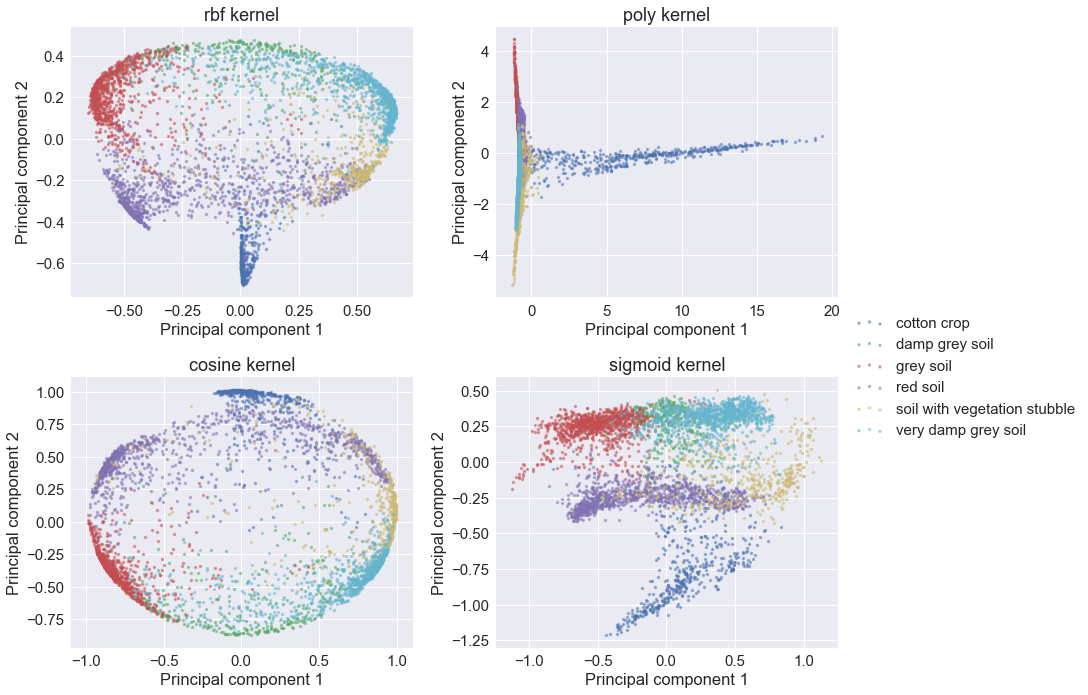

In [55]:
kernels = ['rbf', 'poly', 'cosine', 'sigmoid']

sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(12,10))
for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(xStandard)
    plt.subplot(2,2,ii+1)
    scatter_2d_label(X_kpca_2d, y)
    plt.title('{} kernel'.format(kernel))
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3)
fig.tight_layout()
plt.show()

C:\Users\uss2f\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


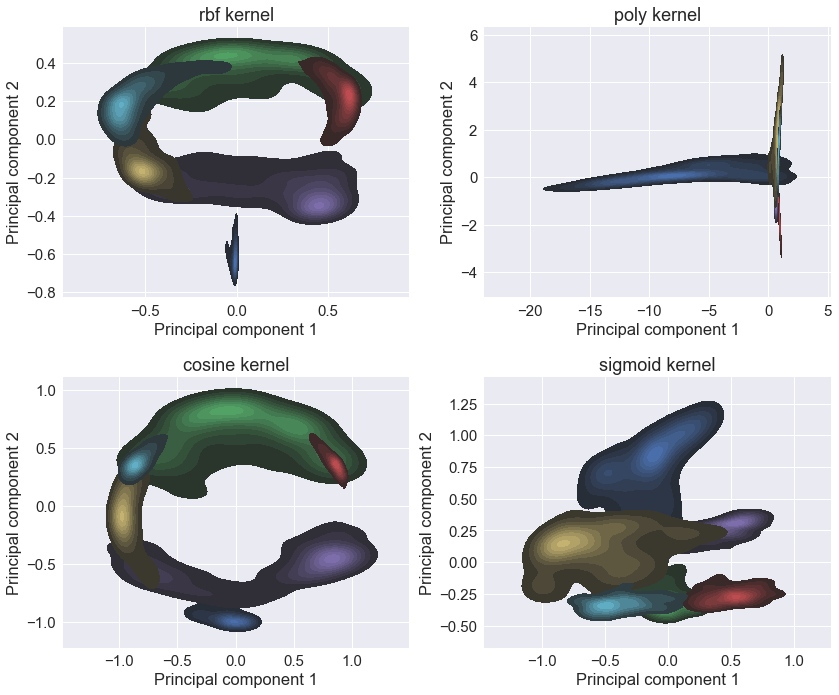

In [64]:
kernels = ['rbf', 'poly', 'cosine', 'sigmoid']
targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(12,10))
for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(xStandard)
    plt.subplot(2,2,ii+1)
    for color, target in zip(colors, targets):
        sns.kdeplot(X_kpca_2d[y == target, 0], X_kpca_2d[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
    plt.title('{} kernel'.format(kernel))
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3)
fig.tight_layout()
plt.show()

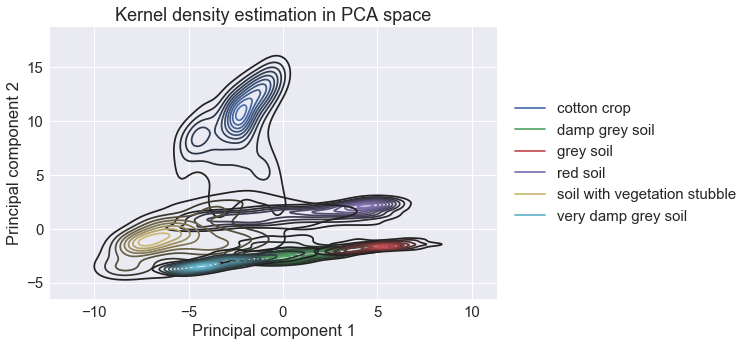

In [60]:
# The following commands are used to create an appropriate legend for the superimposed KDE plots
import matplotlib.lines as mlines
cats = np.unique(y)
color_palette = sns.color_palette(n_colors=cats.size)
patches = [mlines.Line2D([], [], color=color_palette[ii], label=cat) for ii, cat in enumerate(cats)]

plt.figure(figsize=(8,5))
kde_2d_label(X_pca_2d, y)
plt.title('Kernel density estimation in PCA space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

### ========== Question 8 [optional] ========== 

Apply PCA and kernel PCA by using an RBF kernel to:
1. the raw data in `X`
2. the standardised data in `X_sc`. 

What do you observe? Which case seems to be affected by feature standardisation? Can you explain why?

*Hint: Set the `n_components` parameter to `2` and use default settings for other parameters. *

C:\Users\uss2f\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


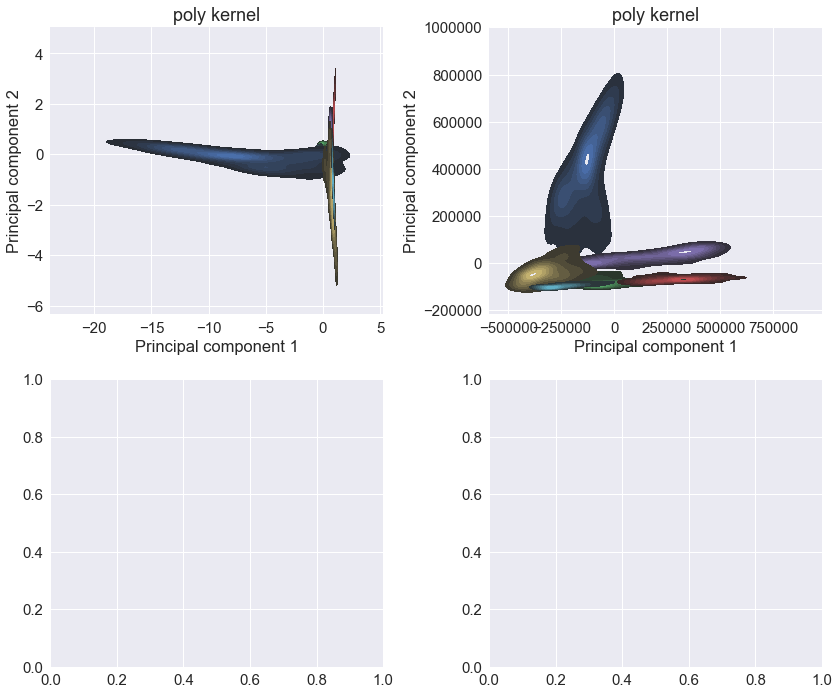

In [65]:
kernels = ['rbf','poly']
targets = np.unique(y)
colors = sns.color_palette(n_colors=targets.size)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(12,10))
for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(xStandard)
    plt.subplot(2,2,1)
    for color, target in zip(colors, targets):
        sns.kdeplot(X_kpca_2d[y == target, 0], X_kpca_2d[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
    plt.title('{} kernel'.format(kernel))
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(x)
    plt.subplot(2,2,2)
    for color, target in zip(colors, targets):
        sns.kdeplot(X_kpca_2d[y == target, 0], X_kpca_2d[y == target, 1], cmap=sns.dark_palette
                (color, as_cmap=True),shade=True, shade_lowest=False)
    plt.title('{} kernel'.format(kernel))
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3)
fig.tight_layout()
plt.show()



## Multidimensional scaling (MDS)

Multidimensional scaling (MDS) refers to a collection of techniques for dimensionality reduction that operate on dissimilarities. The goal of MDS is to find a configuration of points in the plane, or more generally the Euclidean space, so that their distances well represent the original dissimilarities.

We look here into metric MDS (see Section 3.3.1 in the lecture notes). Scikit-learn offers an implentation.  Familiarise yourself with this class by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

### ========== Question 9 ========== 
Use the `MDS` module in scikit-learn to transform the standardised data by using metric MDS. Set `n_components` to `2`, `max_iter` to `100`, `n_init` to `1`, and use default settings for other parameters.  

Visualise the data by using the `scatter_2d_label()` function. What do you observe?

The code returns the value of the objective in (3.31), which is called the `stress_` score and corresponds to the quality of the lower dimensional representation (small values are better).

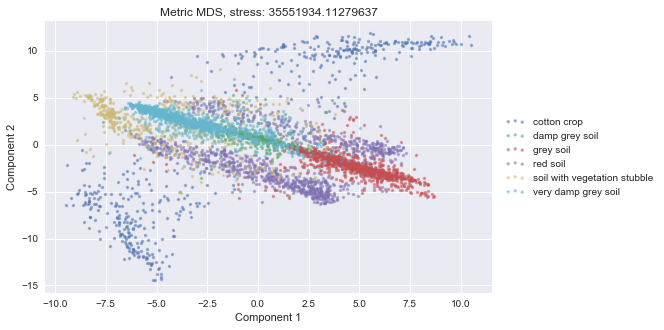

In [66]:
from sklearn.manifold import MDS
# Your code goes here
# Your code goes here
from sklearn.manifold import MDS
sns.set(font_scale=1.)
mds = MDS(n_components=2, metric=True, n_init=1, max_iter=100, random_state=10)
X_mds_2d = mds.fit_transform(xStandard)
plt.figure(figsize=(8,5))
scatter_2d_label(X_mds_2d, y)
plt.title('Metric MDS, stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()


In [ ]:
def scatter_3d_label(X_3d, y, fig=None, s=2, alpha=0.5, lw=2):
    """Visualuse a 3D embedding with corresponding labels.
    
    X_3d : ndarray, shape (n_samples,3)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_3d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    from mpl_toolkits.mplot3d import Axes3D
    if fig is None:
        fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        ax.scatter(X_3d[y == target, 0], X_3d[y == target, 1], X_3d[y == target, 2], 
                    color=color, s=s, label=target, alpha=alpha, lw=lw)
    return (fig, ax)

In [67]:
sns.set(font_scale=1.)
mds = MDS(n_components=3, metric=True, n_init=1, max_iter=100, random_state=10)
X_mds_3d = mds.fit_transform(xStandard)
plt.figure(figsize=(8,5))
scatter_3d_label(X_mds_3d, y)
plt.title('Metric MDS, stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.zlabel('Component 3')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

NameError: name 'scatter_3d_label' is not defined

### ========== Question 10 [optional] ========== 
Observe the outcome of metric MDS by using a [cosine](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) distance this time.

Make sure you set the `dissimilarity` argument appropriately when you construct the `MDS` instance, and you pass the distance matrix when you call the `fit_transform()` method.

Feel free to experiment with other types of distances.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# Your code goes here


## Isomap
MDS does not attempt to explicitly model the underlying data manifold. Isomap, on the other hand, addresses the dimensionality reduction problem by doing so. Suppose your data lie on a curve, but the curve is not a straight line. The key assumption made by Isomap is that the quantity of interest, when comparing two points, is the distance along the curve between the two points. 

In other words, Isomap performs MDS in the geodesic space of the nonlinear data manifold. The geodesic distances represent the shortest paths along the curved surface of the manifold measured as if the surface was flat. This can be approximated by a sequence of short steps between neighbouring sample points. Isomap then applies MDS to the geodesic rather than straight line distances to find a low-dimensional mapping that preserves these pairwise distances.

To summarise, Isomap uses three steps:
1.  Find the neighbours of each data point in high-dimensional data
2.  Compute the geodesic pairwise distances between all points
3.  Embed the data via MDS so as to preserve these distances.


Familiarise yourself with the Isomap class in scikit-learn by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#isomap) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).


### ========== Question 11  ========== 

Project the standardised data into a 2D space by using the Isomap algorithm. Set the `n_components` argument to 2 and explore the role of the `n_neighbours` parameter which defines how many neighbours are used in step 1 above. You can start by trying the following values, but feel free to experiment further: [1, 3, 5, 10, 50, 100]

Use default settings for other parameters.

In [ ]:
from sklearn.manifold import Isomap
# Your code goes here


##  t-distributed Stochastic Neighbor (t-SNE) Embedding

t-SNE is a very powerful tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 

t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space are minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence.

One disadvantage of t-SNE is that it is computationally expensive.  Furthermore, the setting of the various hyper-parameters dramatically affects the results. Considering on top that the algorithm itself is not deterministic, it is obvious that setting these hyper-parameters can be a tricky task.

The **perplexity** parameter is, in a sense, a guess about the number of close neighbors each point has. It is related to the number of nearest neighbors that is used in other manifold learning algorithms like Isomap. The original paper says *“The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50* but, as we will see, depending on the dataset, this parameter can dramatically affect the results.


### ========== Question 12  ========== 

Familiarise yourself with the t-SNE class in scikit-learn by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#t-sne) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Apply t-SNE to the standardised data and explore the role of the `perplexity` input arugment. You can, but are not limited to, try the following values: [2, 5, 10, 30, 50, 100]. 

On top of each scatter plot, display the KL score achieved with each setting. *Hint: look into the `kl_divergence_` attribute of the model.*

What do you think would be a good selection for the perplexity parameter?  

How do you think the performance of t-SNE compares to that of the other methods? Is the distance between neighbouring clusters in the embedded space sensible?

*You will probably notice that your code takes a while to execute (approx. 2-3 mins).*

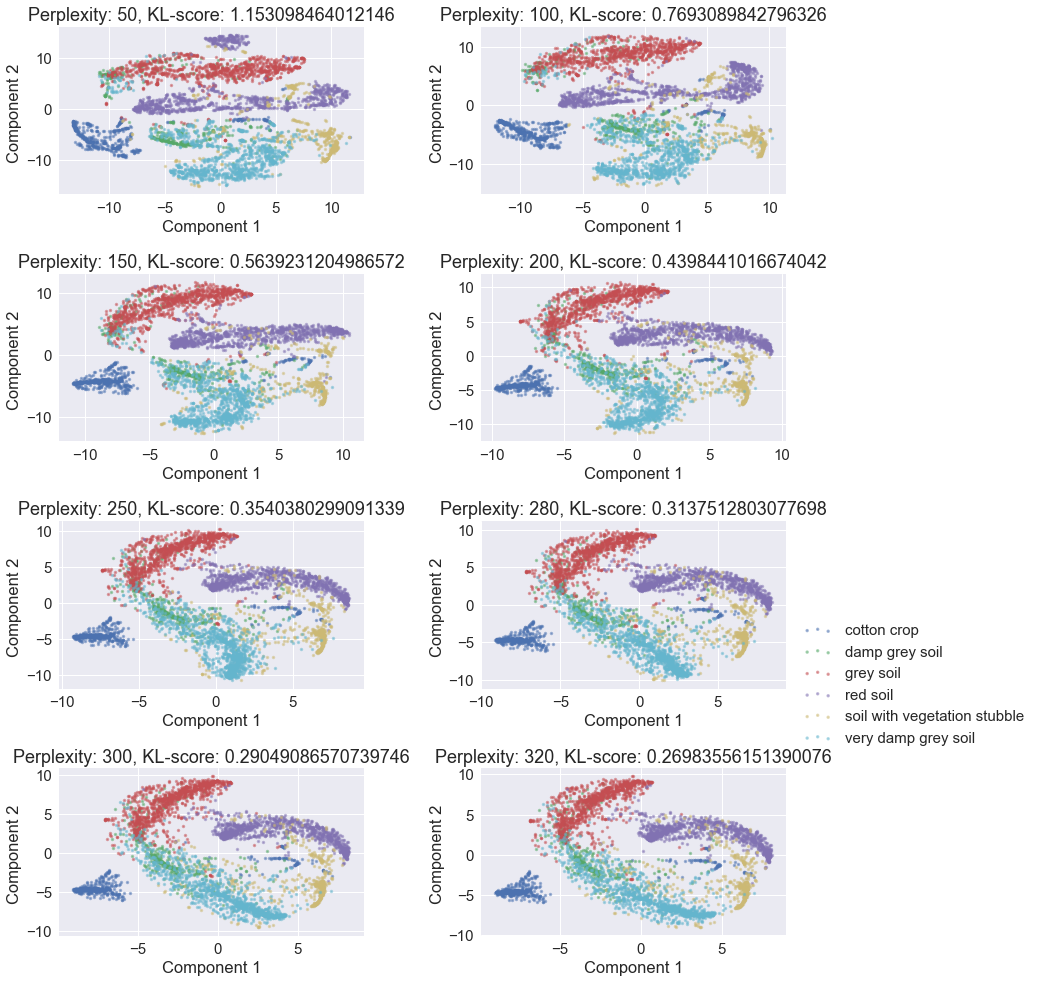

In [11]:
from sklearn.manifold import TSNE
# Your code goes here
from sklearn.manifold import TSNE
# Your code goes here
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(4,2,figsize=(12,14))
for ii, perplexity in enumerate([50, 100,150,200,250,280,300,320]):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=10)
    X_tsne_2d = tsne.fit_transform(xStandard)
    plt.subplot(4,2,ii+1)
    scatter_2d_label(X_tsne_2d, y)
    plt.title('Perplexity: {}, KL-score: {}'.format(perplexity, tsne.kl_divergence_))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()

### Optional

The following webpage provides an excellent interactive introduction to t-SNE, feel free to check it out and experiment further with the various parameters of the algorithm. 

http://distill.pub/2016/misread-tsne/